# Package

In [1]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from pytorch_lightning import loggers
from pytorch_lightning.callbacks import ModelCheckpoint
from tqdm.notebook import tqdm

In [2]:
%load_ext autoreload
%autoreload 2

# Environment config

In [3]:
device = "cuda" if torch.cuda.is_available else "cpu"

def format_bytes(size):
    # 2**10 = 1024
    power = 2**10
    n = 0
    power_labels = {0 : '', 1: 'kilo', 2: 'mega', 3: 'giga', 4: 'tera'}
    while size > power:
        size /= power
        n += 1
    return "%.2f" % size, power_labels[n] + 'bytes'

torch.cuda.get_device_name(), format_bytes(torch.cuda.get_device_properties(device).total_memory)

('GeForce GTX 1080 Ti', ('10.92', 'gigabytes'))

# Load data

In [4]:
from preprocessing.load_sup_dataset import load_train_test

In [5]:
trainset, valset = load_train_test(augmentation = 1)



>> Loading the trainset
Total images are 93408




>> Loading the testset
Total images are 98904




In [24]:
batch_size = 256
trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle = True, num_workers = 4)
valloader = torch.utils.data.DataLoader(valset, batch_size = batch_size, num_workers = 4)
len(trainloader), len(valloader)

(365, 387)

torch.Size([84, 3, 224, 224]) torch.Size([84])


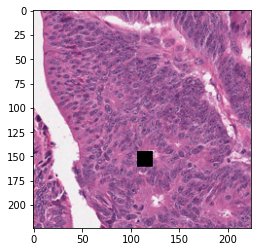

In [7]:
images, labels = next(iter(trainloader))

print(images.shape, labels.shape)
def imshow(img):
    inp = img.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    # plt.show()

imshow(images[0])

# Massive Attention model

In [25]:
from trainer.supervised.massiveattention_trainer import MassiveAttentionTrainer

run_on = "CRC_DX"

In [44]:
massiveattention_trainer = MassiveAttentionTrainer(trainloader, valloader, num_cycle = 3, valset = valset, netname = "resnet18",
                                                  reduce_backbone = None, num_layers = 1)
max_epochs = massiveattention_trainer.get_max_epochs()

In [45]:
checkpoint_path = os.path.join(os.getcwd(), "checkpoint", run_on, "massive_attention")
checkpoint_callback = ModelCheckpoint(
    filepath = checkpoint_path,
    save_top_k = -1,
    verbose = True,
    monitor = 'val_loss',
    mode = 'min'
)

checkpoint_path

'/home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/massive_attention'

In [46]:
tb_logger = loggers.TensorBoardLogger('logs/' + run_on, name = "massiveattention")
trainer = pl.Trainer(checkpoint_callback = checkpoint_callback,
                     nb_sanity_val_steps=0, 
                     max_epochs = max_epochs, 
                     gpus = -1, 
                    logger = tb_logger
                    )

INFO:lightning:GPU available: True, used: True
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]


# Learning rate finder

In [47]:
lr_finder = trainer.lr_find(massiveattention_trainer)

INFO:lightning:
    | Name                                                        | Type               | Params
-----------------------------------------------------------------------------------------------
0   | criterion                                                   | CrossEntropyLoss   | 0     
1   | model                                                       | MassiveAttention   | 24 M  
2   | model.backbone                                              | Sequential         | 11 M  
3   | model.backbone.0                                            | Conv2d             | 9 K   
4   | model.backbone.1                                            | BatchNorm2d        | 128   
5   | model.backbone.2                                            | ReLU               | 0     
6   | model.backbone.3                                            | MaxPool2d          | 0     
7   | model.backbone.4                                            | Sequential         | 147 K 
8   | model.backbone.4.0

>> Reset the optimizer


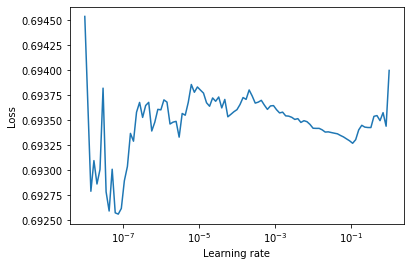

In [48]:
fig = lr_finder.plot(suggest = True)

In [49]:
massiveattention_trainer.base_lr = 8e-5
massiveattention_trainer.max_lr = 9e-3
massiveattention_trainer.configure_optimizers()

>> Reset the optimizer


SGD (
Parameter Group 0
    base_momentum: 0.85
    dampening: 0
    initial_lr: 0.00035999999999999997
    lr: 0.0003599999999999992
    max_lr: 0.009
    max_momentum: 0.95
    min_lr: 3.6e-08
    momentum: 0.95
    nesterov: False
    weight_decay: 1e-05
)

# Start to train the model

In [50]:
trainer.fit(massiveattention_trainer)

INFO:lightning:
    | Name                                                        | Type               | Params
-----------------------------------------------------------------------------------------------
0   | criterion                                                   | CrossEntropyLoss   | 0     
1   | model                                                       | MassiveAttention   | 24 M  
2   | model.backbone                                              | Sequential         | 11 M  
3   | model.backbone.0                                            | Conv2d             | 9 K   
4   | model.backbone.1                                            | BatchNorm2d        | 128   
5   | model.backbone.2                                            | ReLU               | 0     
6   | model.backbone.3                                            | MaxPool2d          | 0     
7   | model.backbone.4                                            | Sequential         | 147 K 
8   | model.backbone.4.0

>> Reset the optimizer


INFO:lightning:
Epoch 00001: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/massive_attention/epoch=1_v7.ckpt


INFO:lightning:
Epoch 00002: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/massive_attention/epoch=2_v6.ckpt


INFO:lightning:
Epoch 00003: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/massive_attention/epoch=3_v5.ckpt


INFO:lightning:
Epoch 00004: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/massive_attention/epoch=4_v5.ckpt


INFO:lightning:
Epoch 00005: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/massive_attention/epoch=5_v5.ckpt


INFO:lightning:
Epoch 00006: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/massive_attention/epoch=6_v5.ckpt


INFO:lightning:
Epoch 00007: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/massive_attention/epoch=7_v5.ckpt


INFO:lightning:
Epoch 00008: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/massive_attention/epoch=8_v5.ckpt


INFO:lightning:
Epoch 00009: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/massive_attention/epoch=9_v5.ckpt


INFO:lightning:
Epoch 00010: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/massive_attention/epoch=10_v5.ckpt


INFO:lightning:
Epoch 00011: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/massive_attention/epoch=11_v5.ckpt


1

# 4 stacked block

In [51]:
from trainer.supervised.massiveattention_trainer import MassiveAttentionTrainer

run_on = "CRC_DX"

In [52]:
massiveattention_trainer = MassiveAttentionTrainer(trainloader, valloader, num_cycle = 3, valset = valset, netname = "resnet18",
                                                  reduce_backbone = None, num_layers = 4)
max_epochs = massiveattention_trainer.get_max_epochs()

In [53]:
checkpoint_path = os.path.join(os.getcwd(), "checkpoint", run_on, "massive_attention")
checkpoint_callback = ModelCheckpoint(
    filepath = checkpoint_path,
    save_top_k = -1,
    verbose = True,
    monitor = 'val_loss',
    mode = 'min'
)

checkpoint_path

'/home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/massive_attention'

In [54]:
tb_logger = loggers.TensorBoardLogger('logs/' + run_on, name = "massiveattention")
trainer = pl.Trainer(checkpoint_callback = checkpoint_callback,
                     nb_sanity_val_steps=0, 
                     max_epochs = max_epochs, 
                     gpus = -1, 
                    logger = tb_logger
                    )

INFO:lightning:GPU available: True, used: True
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]


# Learning rate finder

In [55]:
massiveattention_trainer.base_lr = 8e-5
massiveattention_trainer.max_lr = 9e-3
massiveattention_trainer.configure_optimizers()

>> Reset the optimizer


SGD (
Parameter Group 0
    base_momentum: 0.85
    dampening: 0
    initial_lr: 0.00035999999999999997
    lr: 0.0003599999999999992
    max_lr: 0.009
    max_momentum: 0.95
    min_lr: 3.6e-08
    momentum: 0.95
    nesterov: False
    weight_decay: 1e-05
)

In [56]:
trainer.fit(massiveattention_trainer)

INFO:lightning:
    | Name                                                        | Type               | Params
-----------------------------------------------------------------------------------------------
0   | criterion                                                   | CrossEntropyLoss   | 0     
1   | model                                                       | MassiveAttention   | 19 M  
2   | model.backbone                                              | Sequential         | 11 M  
3   | model.backbone.0                                            | Conv2d             | 9 K   
4   | model.backbone.1                                            | BatchNorm2d        | 128   
5   | model.backbone.2                                            | ReLU               | 0     
6   | model.backbone.3                                            | MaxPool2d          | 0     
7   | model.backbone.4                                            | Sequential         | 147 K 
8   | model.backbone.4.0

>> Reset the optimizer


/home/kientiet/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
INFO:lightning:
Epoch 00000: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/massive_attention/epoch=0_v1.ckpt


INFO:lightning:
Epoch 00001: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/massive_attention/epoch=1_v8.ckpt


INFO:lightning:
Epoch 00002: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/massive_attention/epoch=2_v7.ckpt


INFO:lightning:
Epoch 00003: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/massive_attention/epoch=3_v6.ckpt


INFO:lightning:
Epoch 00004: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/massive_attention/epoch=4_v6.ckpt


INFO:lightning:
Epoch 00005: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/massive_attention/epoch=5_v6.ckpt


INFO:lightning:
Epoch 00006: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/massive_attention/epoch=6_v6.ckpt


INFO:lightning:
Epoch 00007: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/massive_attention/epoch=7_v6.ckpt


INFO:lightning:
Epoch 00008: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/massive_attention/epoch=8_v6.ckpt


INFO:lightning:
Epoch 00009: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/massive_attention/epoch=9_v6.ckpt


INFO:lightning:
Epoch 00010: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/massive_attention/epoch=10_v6.ckpt


INFO:lightning:
Epoch 00011: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/massive_attention/epoch=11_v6.ckpt


1

## 2 blocks

In [57]:
from trainer.supervised.massiveattention_trainer import MassiveAttentionTrainer

run_on = "CRC_DX"

In [58]:
massiveattention_trainer = MassiveAttentionTrainer(trainloader, valloader, num_cycle = 3, valset = valset, netname = "resnet18",
                                                  reduce_backbone = None, num_layers = 2)
max_epochs = massiveattention_trainer.get_max_epochs()

In [59]:
checkpoint_path = os.path.join(os.getcwd(), "checkpoint", run_on, "massive_attention")
checkpoint_callback = ModelCheckpoint(
    filepath = checkpoint_path,
    save_top_k = -1,
    verbose = True,
    monitor = 'val_loss',
    mode = 'min'
)

checkpoint_path

'/home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/massive_attention'

In [60]:
tb_logger = loggers.TensorBoardLogger('logs/' + run_on, name = "massiveattention")
trainer = pl.Trainer(checkpoint_callback = checkpoint_callback,
                     nb_sanity_val_steps=0, 
                     max_epochs = max_epochs, 
                     gpus = -1, 
                    logger = tb_logger
                    )

INFO:lightning:GPU available: True, used: True
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]


In [61]:
massiveattention_trainer.base_lr = 8e-5
massiveattention_trainer.max_lr = 9e-3
massiveattention_trainer.configure_optimizers()

>> Reset the optimizer


SGD (
Parameter Group 0
    base_momentum: 0.85
    dampening: 0
    initial_lr: 0.00035999999999999997
    lr: 0.0003599999999999992
    max_lr: 0.009
    max_momentum: 0.95
    min_lr: 3.6e-08
    momentum: 0.95
    nesterov: False
    weight_decay: 1e-05
)

In [62]:
trainer.fit(massiveattention_trainer)

INFO:lightning:
   | Name                                                        | Type               | Params
-----------------------------------------------------------------------------------------------
0  | criterion                                                   | CrossEntropyLoss   | 0     
1  | model                                                       | MassiveAttention   | 15 M  
2  | model.backbone                                              | Sequential         | 11 M  
3  | model.backbone.0                                            | Conv2d             | 9 K   
4  | model.backbone.1                                            | BatchNorm2d        | 128   
5  | model.backbone.2                                            | ReLU               | 0     
6  | model.backbone.3                                            | MaxPool2d          | 0     
7  | model.backbone.4                                            | Sequential         | 147 K 
8  | model.backbone.4.0          

>> Reset the optimizer


INFO:lightning:
Epoch 00000: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/massive_attention/epoch=0_v2.ckpt


INFO:lightning:
Epoch 00001: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/massive_attention/epoch=1_v9.ckpt


INFO:lightning:
Epoch 00002: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/massive_attention/epoch=2_v8.ckpt


INFO:lightning:
Epoch 00003: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/massive_attention/epoch=3_v7.ckpt


INFO:lightning:
Epoch 00004: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/massive_attention/epoch=4_v7.ckpt


INFO:lightning:
Epoch 00005: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/massive_attention/epoch=5_v7.ckpt


INFO:lightning:
Epoch 00006: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/massive_attention/epoch=6_v7.ckpt


INFO:lightning:
Epoch 00007: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/massive_attention/epoch=7_v7.ckpt


INFO:lightning:
Epoch 00008: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/massive_attention/epoch=8_v7.ckpt


INFO:lightning:
Epoch 00009: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/massive_attention/epoch=9_v7.ckpt


INFO:lightning:
Epoch 00010: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/massive_attention/epoch=10_v7.ckpt


INFO:lightning:
Epoch 00011: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/massive_attention/epoch=11_v7.ckpt


1

# 1 block

In [69]:
from trainer.supervised.massiveattention_trainer import MassiveAttentionTrainer

run_on = "CRC_DX"

In [70]:
massiveattention_trainer = MassiveAttentionTrainer(trainloader, valloader, num_cycle = 3, valset = valset, netname = "resnet18",
                                                  reduce_backbone = None, num_layers = 1)
max_epochs = massiveattention_trainer.get_max_epochs()

In [71]:
checkpoint_path = os.path.join(os.getcwd(), "checkpoint", run_on, "massive_attention")
checkpoint_callback = ModelCheckpoint(
    filepath = checkpoint_path,
    save_top_k = -1,
    verbose = True,
    monitor = 'val_loss',
    mode = 'min'
)

checkpoint_path

'/home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/massive_attention'

In [72]:
tb_logger = loggers.TensorBoardLogger('logs/' + run_on, name = "massiveattention")
trainer = pl.Trainer(checkpoint_callback = checkpoint_callback,
                     nb_sanity_val_steps=0, 
                     max_epochs = max_epochs, 
                     gpus = -1, 
                    logger = tb_logger
                    )

INFO:lightning:GPU available: True, used: True
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]


# Learning rate finder

In [73]:
massiveattention_trainer.base_lr = 8e-5
massiveattention_trainer.max_lr = 9e-3
massiveattention_trainer.configure_optimizers()

>> Reset the optimizer


SGD (
Parameter Group 0
    base_momentum: 0.85
    dampening: 0
    initial_lr: 0.00035999999999999997
    lr: 0.0003599999999999992
    max_lr: 0.009
    max_momentum: 0.95
    min_lr: 3.6e-08
    momentum: 0.95
    nesterov: False
    weight_decay: 1e-05
)

# Start to train the model

In [74]:
trainer.fit(massiveattention_trainer)

INFO:lightning:
   | Name                                                        | Type               | Params
-----------------------------------------------------------------------------------------------
0  | criterion                                                   | CrossEntropyLoss   | 0     
1  | model                                                       | MassiveAttention   | 13 M  
2  | model.backbone                                              | Sequential         | 11 M  
3  | model.backbone.0                                            | Conv2d             | 9 K   
4  | model.backbone.1                                            | BatchNorm2d        | 128   
5  | model.backbone.2                                            | ReLU               | 0     
6  | model.backbone.3                                            | MaxPool2d          | 0     
7  | model.backbone.4                                            | Sequential         | 147 K 
8  | model.backbone.4.0          

>> Reset the optimizer


INFO:lightning:
Epoch 00000: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/massive_attention/epoch=0_v4.ckpt


INFO:lightning:
Epoch 00001: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/massive_attention/epoch=1_v11.ckpt


INFO:lightning:
Epoch 00002: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/massive_attention/epoch=2_v10.ckpt


INFO:lightning:
Epoch 00003: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/massive_attention/epoch=3_v9.ckpt


INFO:lightning:
Epoch 00004: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/massive_attention/epoch=4_v9.ckpt


INFO:lightning:
Epoch 00005: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/massive_attention/epoch=5_v9.ckpt


INFO:lightning:
Epoch 00006: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/massive_attention/epoch=6_v9.ckpt


INFO:lightning:
Epoch 00007: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/massive_attention/epoch=7_v9.ckpt


INFO:lightning:
Epoch 00008: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/massive_attention/epoch=8_v9.ckpt


INFO:lightning:
Epoch 00009: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/massive_attention/epoch=9_v9.ckpt


INFO:lightning:
Epoch 00010: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/massive_attention/epoch=10_v9.ckpt


INFO:lightning:
Epoch 00011: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/massive_attention/epoch=11_v9.ckpt


1